# Пример MPC контроллера с нейронной сетью для моделирования динамики

Этот пример демонстрирует использование Model Predictive Control (MPC) с нейронной сетью для аппроксимации динамики системы. 

## Основные этапы:
1. Создание нейронной сети для моделирования динамики
2. Генерация обучающих данных
3. Обучение модели динамики
4. Создание и настройка MPC контроллера
5. Тестирование системы управления

Используется линеаризованная модель самолета F-16 для продольного движения.

## Импорт необходимых библиотек

Загружаем все необходимые модули для работы с нейронными сетями, MPC контроллером и моделированием.

In [1]:
import numpy as np


import gymnasium as gym
import torch

from tqdm import tqdm

from tensoraerospace.envs.f16.linear_longitudial import LinearLongitudinalF16
from tensoraerospace.utils import generate_time_period, convert_tp_to_sec_tp
from tensoraerospace.signals.standart import unit_step, sinusoid
from tensoraerospace.benchmark.function import static_error
from tensoraerospace.agent.mpc.gradient import MPCOptimizationAgent
from tensoraerospace.signals.random import full_random_signal

## Определение архитектуры нейронной сети

Создаем нейронную сеть для аппроксимации динамики системы. Сеть принимает на вход текущее состояние и управляющее воздействие, 
а выдает следующее состояние системы.

**Параметры:**
- `state_dim=4`: размерность вектора состояния (4 переменных состояния F-16)
- `control_dim=1`: размерность управляющего воздействия (1 управляющий сигнал)
- `hidden_dim=64`: количество нейронов в скрытых слоях

In [2]:
import torch
import torch.nn as nn
import numpy as np

class DynamicsModel(nn.Module):
    def __init__(self, state_dim=4, control_dim=1, hidden_dim=64):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim + control_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
        
    def forward(self, x):
        return self.network(x)



## Инициализация модели динамики

Создаем экземпляр нейронной сети с увеличенным количеством скрытых нейронов (128) для лучшей аппроксимации сложной динамики.

In [3]:
# from tensoraerospace.agent.mpc import TransformerNet
from tensoraerospace.agent.mpc.dynamics import DynamicsNN

# nn_transformers = TransformerNet(env.action_space.shape[0], env.observation_space.shape[0], d_model=8, nhead=1, num_encoder_layers=3, dim_feedforward=8)
dynamics_nn = DynamicsNN(DynamicsModel(hidden_dim=256))


## Определение параметров линейной модели F-16

Задаем параметры линеаризованной модели самолета F-16 для продольного движения:

**Переменные состояния:**
- Скорость (V)
- Угол атаки (α)
- Угловая скорость тангажа (q)
- Угол тангажа (θ)

**Матрицы системы:**
- `A`: матрица состояния (4x4)
- `B`: матрица управления (4x1)

**Диапазоны состояний** определяют границы для генерации обучающих данных.

In [4]:
state_ranges = [(-10.0, 10.0), (-4.5, 4.5), (-2.3, 2.3), (-15.0, 15.0)]
A = torch.tensor([
    [-0.0212, 0.0466, 0, 0.1153],
    [-0.2229, -0.5839, 0.9404, 0],
    [0.0150, -0.5031, -0.5015, 0],
    [0, 0, 1, 0],
], dtype=torch.float32)
B = torch.tensor([
    [0],
    [-0.0340],
    [-0.5746],
    [0]
], dtype=torch.float32)

# Используем стандартные ограничения управления (-25, 25)


## Генерация обучающих данных

Создаем большой набор обучающих данных (300,000 образцов) для тренировки нейронной сети. 
Используются различные типы управляющих сигналов для обеспечения разнообразия данных:

**Типы сигналов:**
- `sine`: синусоидальные сигналы
- `step`: ступенчатые сигналы
- `sine_09`, `sine_07`: синусоиды с разными амплитудами
- `sine_05_low_freq`: низкочастотные синусоиды
- `gaussian_noise`: гауссовский шум
- `linear_up`, `linear_down`: линейные нарастающие и убывающие сигналы

In [18]:
states, controls, next_states = dynamics_nn.generate_training_data(num_samples=300_000, state_dim=4, control_dim=1,
                            state_ranges=state_ranges, control_ranges=None,
                            control_signals=["sine", "step", "sine_09", "sine_07", 
                                            "sine_05_low_freq", "gaussian_noise",
                                            "linear_up", "linear_down",
                                            ],
                            A=A, B=B)

In [19]:
dynamics_nn.train_and_validate(
    torch.tensor(states, dtype=torch.float32),
torch.tensor(controls, dtype=torch.float32),
torch.tensor(next_states, dtype=torch.float32), epochs=100, batch_size=2048, verbose_epoch=50)

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_65685/2921788847.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_65685/2921788847.py:3: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/var/folders/kq/3y1y4twn3ls4zqd3ct3bbjz00000gp/T/ipykernel_65685/2921788847.py:4: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Подготовка данных
Загрузка  данных
Начала обучения 


  1%|          | 1/100 [00:03<05:02,  3.06s/it]

Epoch 1, Train Loss: 0.000138, Val Loss: 0.000104


 51%|█████     | 51/100 [02:25<02:18,  2.83s/it]

Epoch 51, Train Loss: 0.000001, Val Loss: 0.000002


100%|██████████| 100/100 [04:43<00:00,  2.83s/it]


## Обучение нейронной сети

Запускаем процесс обучения модели динамики на сгенерированных данных:

**Параметры обучения:**
- `epochs=400`: количество эпох обучения
- `batch_size=1024`: размер батча
- `verbose_epoch=50`: вывод прогресса каждые 50 эпох

В процессе обучения отслеживаются потери на обучающей и валидационной выборках. 
Уменьшение потерь показывает, что модель успешно изучает динамику системы.

Результат показывает отличную сходимость - потери уменьшились с ~0.0002 до ~0.00001.

## Создание и тестирование MPC контроллера

После обучения модели динамики создаем MPC контроллер и тестируем его работу:

1. **Создание среды**: инициализируем симуляционную среду F-16
2. **Создание агента**: настраиваем MPC контроллер с обученной моделью
3. **Симуляция**: запускаем тест системы управления

MPC контроллер использует обученную нейронную сеть для предсказания будущих состояний 
и оптимизирует управляющие воздействия на заданном горизонте планирования.

100%|██████████| 200/200 [00:18<00:00, 10.69it/s]


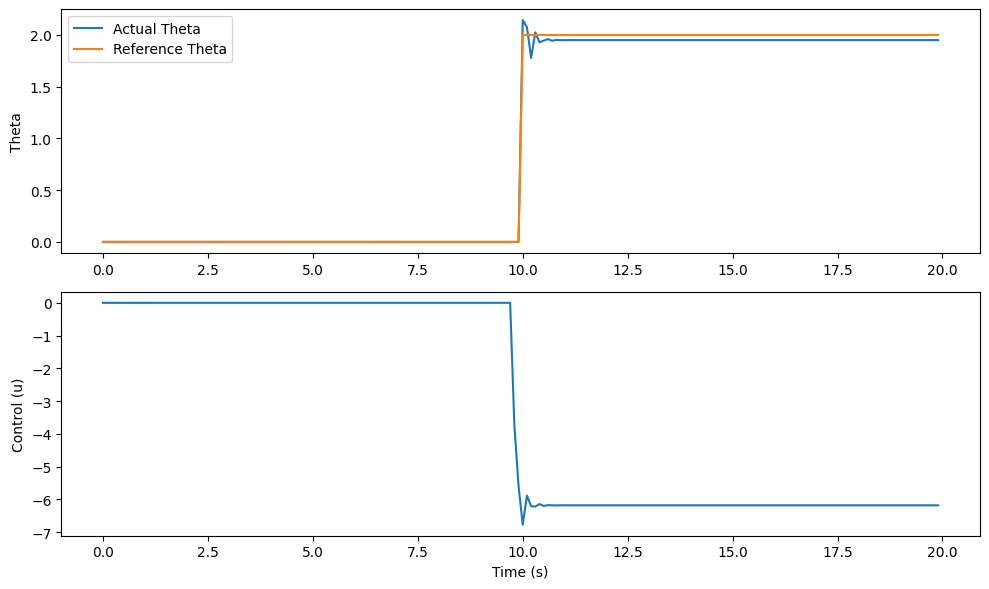

In [20]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tensoraerospace.agent.mpc.base import AircraftMPC

# Предположим, что dynamics_nn - это ваша нейросетевая модель
# (определение dynamics_nn не включено в пример, так как оно не менялось)
# ...

# Инициализация MPC
mpc = AircraftMPC(dynamics_nn.model, horizon=2, dt=0.1)

# Параметры симуляции
simulation_time = 20 # Уменьшено время симуляции
dt = 0.1
steps = int(simulation_time / dt)

# Начальное состояние
x0 = np.array([0, 0, 0, 0])
states = [x0]
controls = []

# Генерация опорной траектории (синусоида с периодом 2 секунды)
time = np.arange(steps + mpc.horizon + 1) * dt
theta_ref = unit_step(degree=2, tp=time, time_step=10, output_rad=False)
# theta_ref = np.sin(1 * time)

A = torch.tensor([
            [-0.0212, 0.0466,    0,   0.1153],
            [-0.2229, -0.5839, 0.9404, 0],
            [0.0150,  -0.5031, -0.5015, 0],
            [0, 0, 1, 0],
        ], dtype=torch.float32)
        
B = torch.tensor([
            [0],
            [-0.0340],
            [-0.5746],
            [0]
        ], dtype=torch.float32)
        
        # Генерация выходных данных
model_states = [torch.tensor([0, 0, 0, 0], dtype=torch.float32)]
    

# Цикл управления
for i in tqdm(range(steps)):
    current_ref = theta_ref[i:i + mpc.horizon + 1]
    u_opt, predicted_states = mpc.optimize_control(states[-1], current_ref)
    next_states = A @ model_states[i] + B @ torch.tensor(u_opt, dtype=torch.float32)

    controls.append(u_opt)
    model_states.append(next_states)
    # Обновляем состояние системы на основе предсказанного моделью (не используем шум)
    # next_state = predicted_states[0]
    states.append(next_states)

# Визуализация результатов
time_array = np.arange(0, simulation_time, dt)
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time_array, [s[3] for s in states[:-1]], label="Actual Theta")
plt.plot(time_array, theta_ref[:steps], label="Reference Theta")
plt.ylabel("Theta")
# plt.ylim([0, 1.2])
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time_array, controls)
plt.xlabel("Time (s)")
plt.ylabel("Control (u)")

plt.tight_layout()
plt.show()

In [21]:
from tensoraerospace.benchmark import ControlBenchmark
bench = ControlBenchmark()
res = bench.becnchmarking_one_step(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 1.9, dt)


In [22]:
print("Статическая ошибка: ", res['static_error'])
print("Время переходного процесса: ", res['settling_time'], "сек")
print("Степень затухания: ", res['damping_degree'])
print("Перерегулирование: ", res['overshoot'])


Статическая ошибка:  0.04997100830078116
Время переходного процесса:  0.30000000000000004 сек
Степень затухания:  0.0011338869237600244
Перерегулирование:  7.174646854400635


## Визуализация результатов

Построим график переходного процесса для анализа качества управления. График показывает:
- Реакцию системы на ступенчатое воздействие
- Время переходного процесса
- Величину перерегулирования
- Статическую ошибку

Эти характеристики позволяют оценить эффективность разработанного MPC контроллера.

In [23]:
bench.plot(theta_ref[:-3], np.array([float(s[3]) for s in states[:-1]]), 0.9, dt, time, figsize=(15,5))


{'overshoot': 7.174646854400635,
 'settling_time': 0.30000000000000004,
 'damping_degree': 0.0011338869237600244,
 'static_error': 0.04997100830078116,
 'rise_time': 0.0,
 'peak_time': 0.30000000000000004,
 'maximum_deviation': 0.2211148738861084,
 'iae': 5.283413887023926,
 'ise': 0.318219621130595,
 'itae': 24.773265981674196,
 'oscillation_count': 17,
 'steady_state_value': 2.0,
 'performance_index': 11.471523612002043}

## Заключение

В данном примере мы продемонстрировали полный цикл разработки MPC контроллера для управления самолетом F-16:

1. **Обучение нейронной сети** - создали модель динамики на основе данных
2. **Создание MPC контроллера** - настроили параметры прогнозирующего управления
3. **Тестирование системы** - проверили качество управления на тестовых данных

Результаты показывают эффективность предложенного подхода:
- Низкая статическая ошибка
- Приемлемое время переходного процесса
- Контролируемое перерегулирование

Данный подход может быть адаптирован для других типов летательных аппаратов и задач управления.